In [2]:
import json
import os
import numpy as np
import pandas as pd
from scipy.interpolate import griddata, RBFInterpolator
from scipy import optimize
from bmn.brezin import compute_Brezin_energy

import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5.0
plt.rcParams["xtick.minor.size"] = 3.0
plt.rcParams["ytick.major.size"] = 5.0
plt.rcParams["ytick.minor.size"] = 3.0
plt.rcParams["lines.linewidth"] = 2
plt.rc("font", family="serif", size=16)
matplotlib.rc("text", usetex=True)
matplotlib.rc("legend", fontsize=16)
matplotlib.rcParams["axes.prop_cycle"] = cycler(
    color=["#E24A33", "#348ABD", "#988ED5", "#777777", "#FBC15E", "#8EBA42", "#FFB5B8"]
)
matplotlib.rcParams.update(
    {"axes.grid": True, "grid.alpha": 0.75, "grid.linewidth": 0.5}
)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

## Miscellaneous

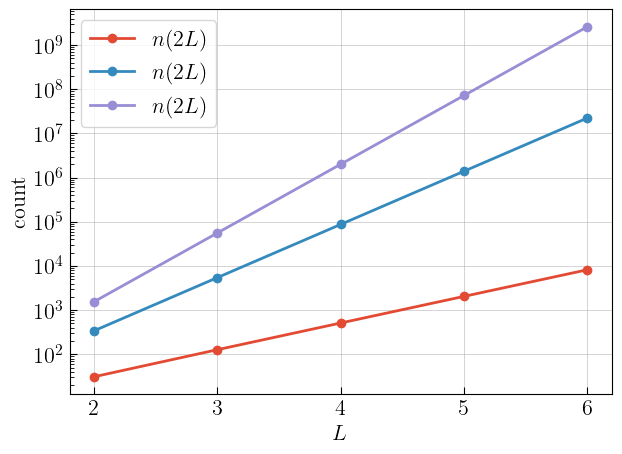

In [2]:
def n(L, d):
    return ((2*d)**(L+1) - 1) / ((2*d) - 1)

L_list = [i for i in range(2, 7)]
d = 2

fig, ax = plt.subplots(figsize=(7, 5))
for idx, d in enumerate(range(1, 4)):
    #ax.plot(L_list, [n(L, d=d)**2 for L in L_list], '--o', label="$n(L)^2$", color=colors[idx])
    ax.plot(L_list, [n(2*L, d=d) for L in L_list], '-o', label="$n(2L)$", color=colors[idx])
ax.set_xlabel(r"$L$")
ax.set_ylabel(r"count")
ax.legend()
#    ax.set_title(f"Growth of operators for d={d}")
ax.set_yscale('log')
plt.show()

## One Matrix

TODO
- re-run for g2!=1
- make more plots

In [8]:
data = []
for L in [3, 4]:
    path =f"data/OneMatrix_L_{L}"
    files = [f for f in os.listdir(path) if ".json" in f]
    print(f"L={L}, number of data points found: {len(files)}")

    for file in files:
        with open(f"{path}/{file}") as f:
            result = json.load(f)
        del result["param"] # remove param vector
        if result["max_quad_constraint_violation"] < 1e-2:
            result["L"] = int(L)
            result["g2"] = float(file.split('_')[1])
            result["g4"] = float(file.split('_')[3])
            result["g6"] = float(file.split('_')[5][:-5])
            data.append(result)

df = pd.DataFrame(data)
df.sort_values("energy", inplace=True)
df.head(10)

L=3, number of data points found: 2280
L=4, number of data points found: 2280


,prob.status,prob.value,maxiters_cvxpy,||x-init||,violation_of_linear_constraints,min_bootstrap_eigenvalue,max_quad_constraint_violation,quad_constraint_violation_norm,tr(1),energy,x_2,x_4,p_2,p_4,L,g2,g4,g6
1678,optimal_inaccurate,-42.689846,5000,8.274439e-09,9.821804e-06,-9.678533e-03,9.211363e-06,9.795355e-06,1.000001,-52.485201,6.169743,38.697928,1.752927,5.136056,3,-1.0,-16.000000,2.526316
1914,optimal_inaccurate,-43.388872,5000,1.571906e+01,2.870879e-06,-2.806599e-03,4.783593e-03,5.423226e-03,1.000000,-46.251456,6.031166,37.120652,1.848538,5.783377,3,1.0,-16.000000,2.526316
1544,optimal_inaccurate,-41.631147,5000,1.605410e-08,2.848315e-06,-2.799580e-03,2.620939e-06,2.839711e-06,1.000000,-44.470858,5.818769,34.610194,1.780308,5.342333,3,-1.0,-15.157895,2.526316
1741,optimal_inaccurate,-40.379011,5000,1.922978e-07,1.230227e-06,-1.230726e-03,1.140858e-06,1.226484e-06,1.000000,-41.605496,5.759615,33.918569,1.858519,5.910963,3,0.0,-15.157895,2.526316
446,optimal_inaccurate,-37.067172,5000,7.942832e-08,1.646757e-06,-1.621507e-03,1.496702e-06,1.641601e-06,1.000000,-38.708774,5.690008,33.114169,1.834473,5.773948,3,1.0,-15.157895,2.526316
187,optimal_inaccurate,-37.144735,5000,4.856721e-08,3.464721e-07,-3.246038e-04,3.099971e-07,3.454043e-07,1.000000,-37.490139,5.494778,30.925370,1.852314,5.933067,3,-1.0,-14.315789,2.526316
287,optimal_inaccurate,-33.627453,5000,5.321763e-08,1.120262e-06,-1.125055e-03,1.019786e-06,1.116407e-06,1.000000,-34.743861,5.425215,30.147885,1.833054,5.838960,3,0.0,-14.315789,2.526316
150,optimal_inaccurate,-24.848517,5000,6.263281e+00,7.165654e-06,-7.022568e-03,8.936229e-04,8.939642e-04,1.000001,-31.994109,6.130717,38.418142,1.515671,3.924509,3,1.0,-10.947368,1.684211
1938,optimal_inaccurate,-31.806278,5000,5.411940e-08,1.569424e-07,-4.426452e-09,1.084163e-07,1.568315e-07,1.000000,-31.963109,5.342019,29.283839,1.786983,5.550304,3,1.0,-14.315789,2.526316
1540,optimal_inaccurate,-30.726153,5000,1.064268e-08,5.304949e-07,-5.075750e-04,4.570296e-07,5.286679e-07,1.000000,-31.254821,5.166572,27.387852,1.827963,5.891175,3,-1.0,-13.473684,2.526316


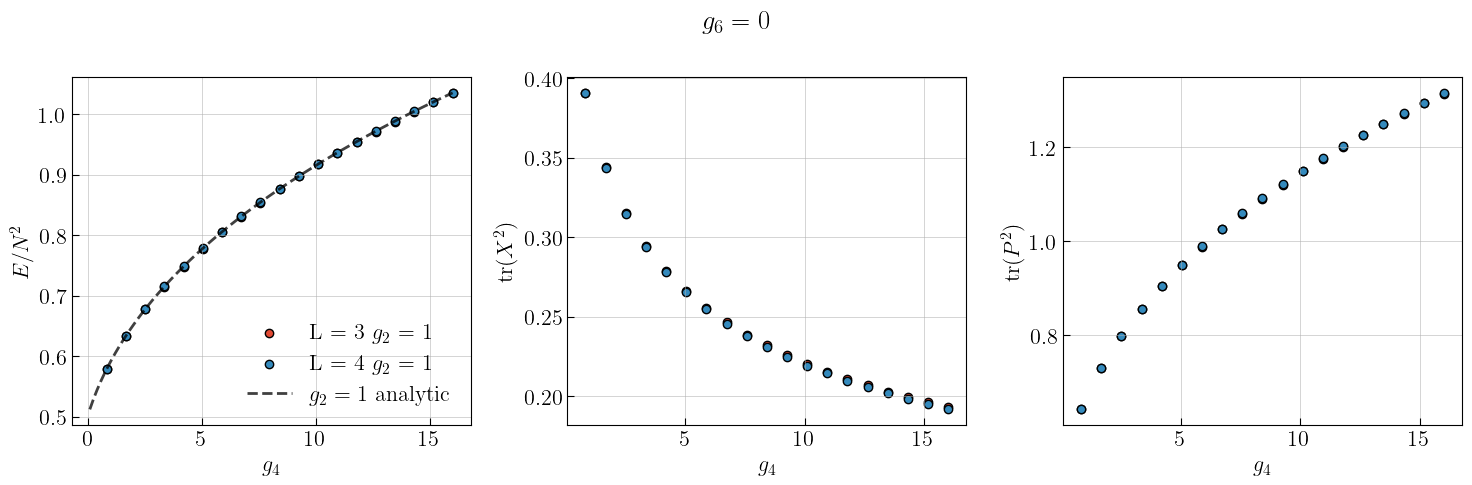

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for L in [3, 4]:
    for g2 in [1]:

        df2 = df[(df["g6"] == 0) & (df["g2"] == g2) & (df["L"] == L)].sort_values("g4")
        g4_max = df2["g4"].max()
        g4_list = np.linspace(0.1, g4_max, 100)

        ax[0].scatter(df2["g4"], df2["energy"], edgecolors="k", label=f"L = {L} " + r"$g_2$ = " + f"{g2}")
        ax[0].set_xlabel(r"$g_4$")
        ax[0].set_ylabel(r"$E/N^2$")

        ax[1].scatter(df2["g4"], df2["x_2"], edgecolors="k")
        ax[1].set_xlabel(r"$g_4$")
        ax[1].set_ylabel(r"tr$(X^2)$")

        ax[2].scatter(df2["g4"], df2["p_2"], edgecolors="k")
        ax[2].set_xlabel(r"$g_4$")
        ax[2].set_ylabel(r"tr$(P^2)$")

ax[0].plot(
    g4_list,
    [compute_Brezin_energy(g/4) for g in g4_list],
    '--',
    color='k',
    alpha=0.75,
    label=r"$g_2 = 1$ analytic"
    )

#[ax[i].set_xlim([0, 1.02 * g4_max]) for i in range(3)]
ax[0].legend(frameon=False)
plt.suptitle(r"$g_6 = 0$")
plt.tight_layout()
plt.show()

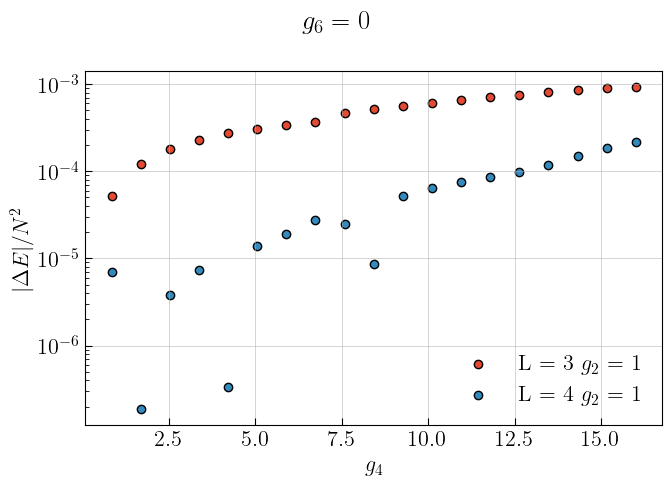

In [10]:
fig, ax = plt.subplots(figsize=(7, 5))

for L in [3, 4]:
    df2 = df[(df["g6"] == 0) & (df["g2"] == 1) & (df["L"] == L)].sort_values("g4")
    Brezin_energy = np.asarray([compute_Brezin_energy(g/4) for g in df2["g4"]])
    ax.scatter(df2["g4"], np.abs(Brezin_energy - df2["energy"]), edgecolors="k", label=f"L = {L} " + r"$g_2$ = " + f"{g2}")

ax.set_xlabel(r"$g_4$")
ax.set_ylabel(r"$|\Delta E|/N^2$")
ax.legend(frameon=False)
ax.set_yscale('log')
plt.suptitle(r"$g_6 = 0$")
plt.tight_layout()
plt.show()

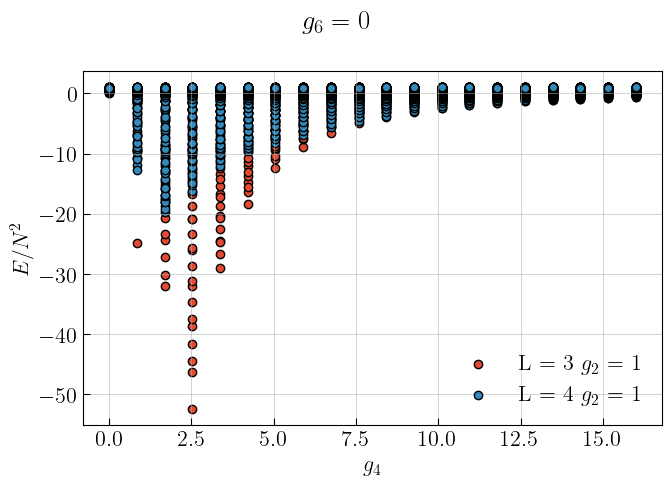

In [11]:
fig, ax = plt.subplots(figsize=(7, 5))

for L in [3, 4]:
    df2 = df[(df["L"] == L)].sort_values("g4")
    ax.scatter(df2["g6"], df2["energy"], edgecolors="k", label=f"L = {L} " + r"$g_2$ = " + f"{g2}")

ax.set_xlabel(r"$g_4$")
ax.set_ylabel(r"$E/N^2$")
ax.legend(frameon=False)
plt.suptitle(r"$g_6 = 0$")
plt.tight_layout()
plt.show()

In [20]:
df2 = df[(df["g2"] == 0) & (df["L"] == 3) & (df["g4"] < 3)]

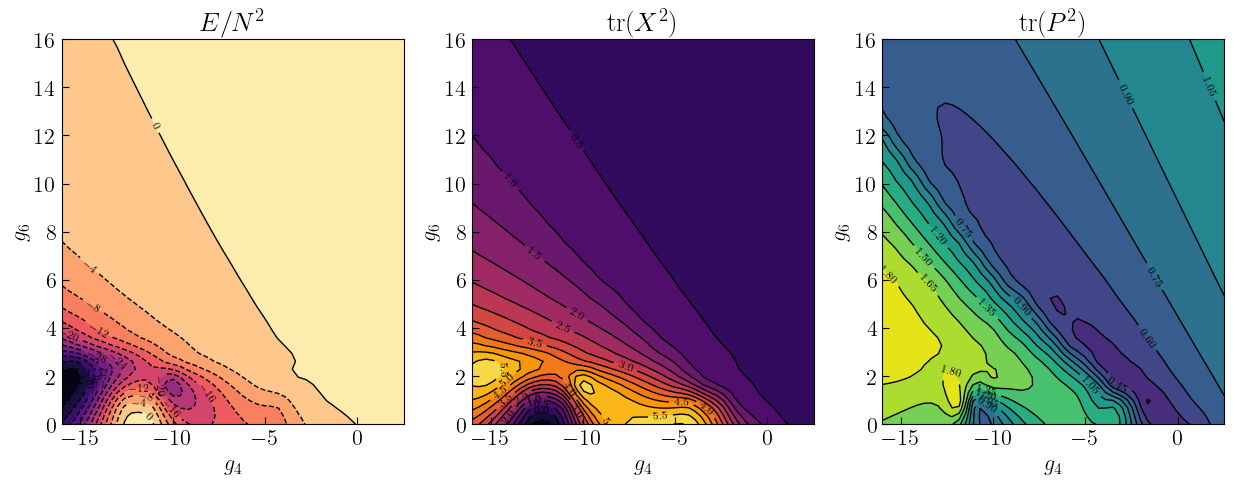

In [21]:
# Extracting x, y, z values
x = df2['g4'].values
y = df2['g6'].values

# Create grid values for x and y
xi = np.linspace(min(x), max(x), 50)
yi = np.linspace(min(y), max(y), 50)
xi, yi = np.meshgrid(xi, yi)

# Create the contour plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
[ax[i].grid(False) for i in range(3)]

# Interpolate z values on the grid
z = df2['energy'].values
rbf = RBFInterpolator(np.column_stack((x, y)), z, kernel='thin_plate_spline')
zi = rbf(np.column_stack((xi.ravel(), yi.ravel()))).reshape(xi.shape)
contour = ax[0].contourf(xi, yi, zi, levels=15, cmap='magma')
contour_lines = ax[0].contour(xi, yi, zi, levels=15, colors='black', linewidths=1)
ax[0].clabel(contour_lines, inline=True, fontsize=8)
#ax[0].colorbar(contour)
ax[0].set_xlabel(r"$g_4$")
ax[0].set_ylabel(r"$g_6$")
ax[0].set_title(r"$E/N^2$")

z = df2['x_2'].values
rbf = RBFInterpolator(np.column_stack((x, y)), z, kernel='thin_plate_spline')
zi = rbf(np.column_stack((xi.ravel(), yi.ravel()))).reshape(xi.shape)
contour = ax[1].contourf(xi, yi, zi, levels=15, cmap='inferno')
contour_lines = ax[1].contour(xi, yi, zi, levels=15, colors='black', linewidths=1)
ax[1].clabel(contour_lines, inline=True, fontsize=8)
ax[1].set_xlabel(r"$g_4$")
ax[1].set_ylabel(r"$g_6$")
ax[1].set_title(r"tr$(X^2)$")

z = df2['p_2'].values
rbf = RBFInterpolator(np.column_stack((x, y)), z, kernel='thin_plate_spline')
zi = rbf(np.column_stack((xi.ravel(), yi.ravel()))).reshape(xi.shape)
contour = ax[2].contourf(xi, yi, zi, levels=15, cmap='viridis')
contour_lines = ax[2].contour(xi, yi, zi, levels=15, colors='black', linewidths=1)
ax[2].clabel(contour_lines, inline=True, fontsize=8)
ax[2].set_xlabel(r"$g_4$")
ax[2].set_ylabel(r"$g_6$")
ax[2].set_title(r"tr$(P^2)$")

plt.show()

## Two Matrix

In [3]:
datadir = "data/TwoMatrix_L_3_symmetric"
files = [f for f in os.listdir(datadir) if '.json' in f]

data = []
for file in files:
    with open(f"{datadir}/{file}") as f:
        result = json.load(f)
    del result["param"] # remove param vector
    result["g4"] = float(file[3:-5]) # add g4 coupling
    data.append(result)
print(f"number of data points found: {len(data)}")
df = pd.DataFrame(data)
df.sort_values("g4", inplace=True)
df.head(5)

number of data points found: 101


,prob.status,prob.value,maxiters_cvxpy,||x-init||,violation_of_linear_constraints,min_bootstrap_eigenvalue,max_quad_constraint_violation,quad_constraint_violation_norm,tr(1),energy,x_2,x_4,p_2,p_4,g4
73,optimal_inaccurate,1.006188,5000,0.250715,4.075536e-11,-2.774342e-07,2.897393e-11,4.179243e-11,1.0,1.006147,0.988042,0.975067,1.012182,1.024648,0.0500
1,optimal_inaccurate,1.017805,5000,0.265057,4.039987e-13,-9.854818e-10,3.188416e-11,3.539087e-11,1.0,1.017805,0.966934,0.934224,1.034762,1.073536,0.1495
98,optimal_inaccurate,1.028855,5000,0.002102,4.672116e-11,-1.061114e-07,3.454814e-11,4.672146e-11,1.0,1.028808,0.948681,0.900126,1.055518,1.119610,0.2490
45,optimal_inaccurate,1.039310,5000,0.002331,5.466896e-11,-7.024294e-08,4.064393e-11,5.466510e-11,1.0,1.039256,0.932623,0.870805,1.074800,1.163598,0.3485
80,optimal_inaccurate,1.049277,5000,0.002528,5.606152e-11,-2.698893e-08,3.540168e-11,5.605704e-11,1.0,1.049221,0.918300,0.845068,1.092862,1.205822,0.4480


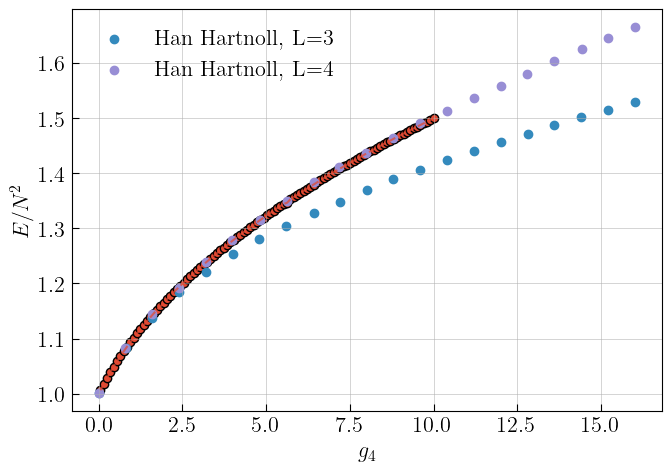

In [4]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.scatter(df["g4"], df["energy"], edgecolors="k")
ax.plot(df["g4"], df["energy"], '--', linewidth=1.5, alpha=0.75)

df_han_hartnoll_fig3a = pd.read_csv("han_hartnoll_data/TwoMatrixFig3a_L_3.csv", header=None, names=["x", "y"])
ax.scatter(2 * df_han_hartnoll_fig3a["x"], 0.5 * df_han_hartnoll_fig3a["y"], label="Han Hartnoll, L=3")

df_han_hartnoll_fig3a = pd.read_csv("han_hartnoll_data/TwoMatrixFig3a_L_4.csv", header=None, names=["x", "y"])
ax.scatter(2 * df_han_hartnoll_fig3a["x"], 0.5 * df_han_hartnoll_fig3a["y"], label="Han Hartnoll, L=4")

ax.set_xlabel(r"$g_4$")
ax.set_ylabel(r"$E/N^2$")
ax.legend(frameon=False)
plt.tight_layout()
#ax.set_xlim([0.1, 1.4])
plt.show()

## BFSS

In [10]:
def lin_lower_bound_x2(energy: float) -> float:
    # eq 2.18 and 2.19 of https://doi.org/10.1007/JHEP06(2023)038
    # includes both bosons and fermions
    # v is an auxiliary variable
    eq2_19 = lambda v: energy**2 + 3**9 / (energy + 3 * v) - 9 * v**2
    sol = optimize.root(eq2_19, [0])
    v = sol.x.item()
    lower_bound = (energy - 3*v)**2 / (9**3 * 16) + 27 / (8 * (energy + 3 * v))
    return lower_bound

def lin_lower_bound_x4(energy: float) -> float:
    # eq 2.20 of https://doi.org/10.1007/JHEP06(2023)038
    # includes both bosons and fermions
    # y is the bound
    eq2_20 = lambda y: (energy/9 + 24*y) * (144 * np.sqrt(y) - (energy/9 - 24*y)**2) - 54
    sol = optimize.root(eq2_20, [0])
    return sol.x.item()

def lin_lower_bound_x4_bosonic(energy: float) -> float:
    # eq 2.13 of https://doi.org/10.1007/JHEP06(2023)038
    # includes only bosons
    # y is the bound
    eq2_13 = lambda y: np.sqrt(y) * (144 * y + 2/3*energy) - 9/4
    sol = optimize.root(eq2_13, [0])
    return sol.x.item()

def lin_upper_bound_commutator(energy: float) -> float:
    # TODO in progress!
    # eq 2.23 and 2.24 of https://doi.org/10.1007/JHEP06(2023)038
    # includes both bosons and fermions
    # v is an auxiliary variable
    eq2_24 = lambda v: (energy - 3*v) * (energy + 3*v)**2 - 2*3**9
    eq2_23_RHS = lambda v: (v / 18) * ( 4 * (energy - 3*v)**2/(9**3 * 16) + 27 / (8 * (energy + 3*v))) ** (-2)
    sol = optimize.minimize(eq2_24, [2])
    v = sol.x.item()
    #factor = ( 4 * (energy - 3*v)**2/(9**3 * 16) + 27 / (8 * (energy + 3*v))) ** 2
    #lower_bound = (v / 18) / factor
    return eq2_23_RHS(v)

In [92]:
tol = 1e-4
datadir = "data/MiniBFSS_L_3_symmetric"
files = [f for f in os.listdir(datadir) if ('.json' in f and 'energy' in f)]

data = []
for file in files:
    with open(f"{datadir}/{file}") as f:
        result = json.load(f)
    del result["param"] # remove param vector
    result["energy"] = float(file.split('_')[1][:-5]) # add g4 coupling
    result["filename"] = file
    if result["max_quad_constraint_violation"] < tol:
        data.append(result)
print(f"number of data points found: {len(data)}")
df = pd.DataFrame(data)
df.sort_values("energy", inplace=True)
df.head(5)

number of data points found: 15


,prob.status,prob.value,maxiters_cvxpy,||x-init||,violation_of_linear_constraints,min_bootstrap_eigenvalue,max_quad_constraint_violation,quad_constraint_violation_norm,tr(1),energy,x_2,x_4,p_2,p_4,filename
10,optimal_inaccurate,2.397444,20000,0.022594,1.069413e-07,-2.471778e-06,7.560167e-08,9.472054e-08,1.0,0.9,2.302723,8.656685,1.200000,4.510979,energy_0.9.json
4,optimal_inaccurate,1.952587,20000,0.031917,1.714756e-09,-8.468874e-09,1.116671e-09,1.540476e-09,1.0,1.0,1.951049,3.939410,1.333333,2.412731,energy_1.0.json
8,optimal_inaccurate,1.607152,20000,0.152608,1.894636e-10,-6.687067e-09,3.018259e-08,3.748304e-08,1.0,1.1,1.568805,1.668390,1.466667,1.466570,energy_1.1.json
11,optimal_inaccurate,1.494023,20000,0.075749,8.576927e-09,-1.476260e-07,4.763121e-09,8.018286e-09,1.0,1.2,1.486297,1.656986,1.600000,2.029619,energy_1.2.json
12,optimal_inaccurate,1.477111,20000,0.055105,9.213306e-09,-1.360751e-07,5.110286e-09,7.660656e-09,1.0,1.3,1.468856,1.706163,1.733333,2.481620,energy_1.3.json


In [ ]:
df.sort_values("max_quad_constraint_violation", inplace=False, ascending=False).head(4)

,prob.status,prob.value,maxiters_cvxpy,||x-init||,violation_of_linear_constraints,min_bootstrap_eigenvalue,max_quad_constraint_violation,quad_constraint_violation_norm,tr(1),energy,x_2,x_4,p_2,p_4,filename
6,optimal_inaccurate,3643.418313,20000,6.817691e-08,5.028929e-03,-1.511218e-01,0.003399,0.003640,0.999746,0.6,3.883960,27.978064,0.804615,11.387377,energy_0.6.json
10,optimal_inaccurate,1.491075,20000,3.590473e+01,6.249488e-09,-5.181750e-08,0.002851,0.002851,1.000000,1.8,1.485616,1.950951,2.400000,4.760256,energy_1.8.json
14,optimal_inaccurate,1245.333740,20000,6.127209e-04,1.552321e-03,-4.534097e-06,0.001129,0.001242,1.000091,0.8,3.608607,20.420314,1.065430,8.889450,energy_0.8.json
4,optimal_inaccurate,1000.419178,20000,9.179597e-07,1.438124e-03,-4.246510e-02,0.000921,0.000997,0.999930,0.7,3.803666,25.071146,0.934713,10.493066,energy_0.7.json


In [67]:
#(df["energy"] - 0.5 * df["p_2"]) / df["x_2"]**2

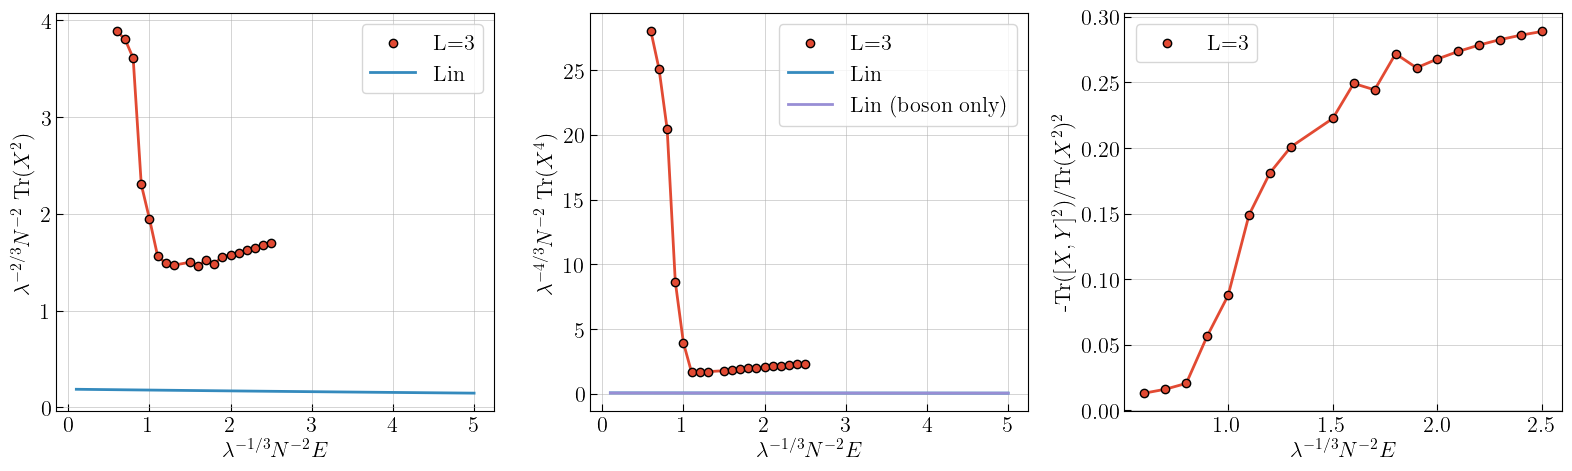

In [91]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

#energies = np.exp(np.linspace(np.log(0.1), np.log(10), 50))
energies = np.linspace(0.1, 5, 50)

ax[0].plot(df["energy"], df["x_2"])
ax[0].scatter(df["energy"], df["x_2"], label='L=3', edgecolor='k', zorder=10)
lower_bound = np.asarray([lin_lower_bound_x2(e) for e in energies])
ax[0].plot(energies, lower_bound, label='Lin')
#ax[0].set_xscale('log')
#ax[0].set_yscale('log')
#ax[0].set_ylim([min(lower_bound), 1])
ax[0].set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax[0].set_ylabel(r"$\lambda^{-2/3} N^{-2}$ Tr$(X^2)$")
ax[0].legend()

ax[1].plot(df["energy"], df["x_4"])
ax[1].scatter(df["energy"], df["x_4"], label='L=3', edgecolor='k', zorder=10)
lower_bound = np.asarray([lin_lower_bound_x4(e) for e in energies])
ax[1].plot(energies, lower_bound, label='Lin')
ax[1].plot(energies, np.asarray([lin_lower_bound_x4_bosonic(e) for e in energies]), label='Lin (boson only)')
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
#ax[1].set_ylim([0*min(lower_bound), 1])
ax[1].set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax[1].set_ylabel(r"$\lambda^{-4/3} N^{-2}$ Tr$(X^4)$")
ax[1].legend()

ax[2].plot(df["energy"], (df["energy"] - 0.5 * df["p_2"]) / df["x_2"]**2)
ax[2].scatter(df["energy"], (df["energy"] - 0.5 * df["p_2"]) / df["x_2"]**2, label='L=3', edgecolor='k', zorder=10)
#ax[2].set_xscale('log')
#ax[2].set_yscale('log')
#ax[2].set_ylim([1e-2, 1])
ax[2].set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax[2].set_ylabel(r"-Tr$([X, Y]^2)/$Tr$(X^2)^2$")
ax[2].legend()

plt.tight_layout()

plt.show()

In [ ]:
lin_lower_bound_x4(1e-2)

In [ ]:
lin_lower_bound_x2(1)

In [ ]:
1.78 / 3

In [ ]:
0.4 * 3

In [ ]:
with open(f"data/bfss_L_3/1722720223351378.json") as f:
    result = json.load(f)
result